In [1]:
import networkx as nx

import pandas as pd
from operator import itemgetter
import matplotlib.pyplot as plt
import collections
from community import community_louvain
from networkx.algorithms.community.centrality import girvan_newman
import itertools
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
nx.__version__

'2.2'

### Installation

```
pip install networkx python-louvain
```

### Introducting Networkx

NetworkX has a broad range of example networks that you can load with just call ([more examples here](https://networkx.github.io/documentation/stable/auto_examples/index.html)).

.. and a super friendly API that you can use to conviently build networks

In order to get use to NetworkX API, let's just construct a simple **undirected graph**

In [4]:
G = nx.Graph()
G.add_node(1)
G.add_nodes_from(range(2,9))  # add multiple nodes at once

# add edges 
G.add_edge(1,2)
edges = [(2,3), (1,3), (4,1), (4,5), (5,6), (5,7), (6,7), (7,8), (6,8)]
G.add_edges_from(edges)
G.nodes()

NodeView((1, 2, 3, 4, 5, 6, 7, 8))

Did you like to get a quick overview of your dataset using `.describe()` in pandas ?
Here is the equivalent in NetworkX:

In [5]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 8
Number of edges: 10
Average degree:   2.5000


The library also has a built-in plotting engine (based on matplotlib).

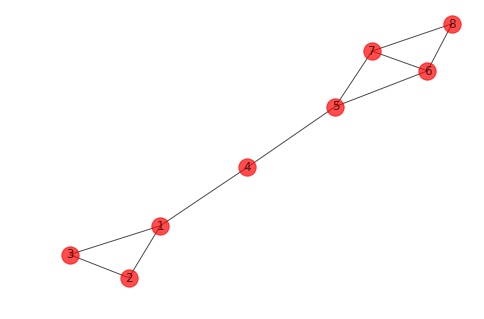

In [6]:
# plot it out
nx.draw_spring(G, with_labels=True,  alpha = 0.7)

### Section 2: Quakers !

Let's now go beyond toy examples and load real data! 

England, in the mid-17th century. A novel group of Protestant Christians, called "Religious Society of Friends" dissent from the main doctrine. Their members are known as the "Quackers". This dataset is derived from the ["Oxford Dictionary of National Biography"](http://www.oxforddnb.com/) and from the ongoing work of the "Six Degrees of Francis Bacon project", which is reconstructing the social networks of early modern Britain (1500-1700).

[Credits](https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python)

#### Meet the quakers

In [7]:
data_folder = './data/quackers/'
nodes = pd.read_csv(data_folder + 'quakers_nodelist.csv')
nodes.head(10)

,Name,Historical Significance,Gender,Birthdate,Deathdate,ID
0,Joseph Wyeth,religious writer,male,1663,1731,10013191
1,Alexander Skene of Newtyle,local politician and author,male,1621,1694,10011149
2,James Logan,colonial official and scholar,male,1674,1751,10007567
3,Dorcas Erbery,Quaker preacher,female,1656,1659,10003983
4,Lilias Skene,Quaker preacher and poet,male,1626,1697,10011152
5,William Mucklow,religious writer,male,1630,1713,10008595
6,Thomas Salthouse,Quaker preacher and writer,male,1630,1691,10010643
7,William Dewsbury,Quaker activist,male,1621,1688,10003478
8,John Audland,Quaker preacher,male,1630,1664,10000411
9,Richard Claridge,Quaker minister and schoolmaster,male,1649,1723,10002469


In [8]:
nodes.Gender = nodes.Gender.astype('category')
nodes = nodes.rename({'Historical Significance': 'Role'}, axis = 1)
print('There are ', len(nodes), 'quakers')

There are  119 quakers


In [9]:
nodes['Role'].isna().sum()

2

In [10]:
# some don't have a known 'historical significance'
nodes['Role'].fillna('Unknown', inplace=True)

In [11]:
# unique names
len(nodes['Name'].unique()) == len(nodes)

True

In [12]:
# since the names are unique, index based on names
nodes.set_index('Name', inplace=True)
nodes.head()

# let's also add a new attribute based on the role column. Is (s)he a directly involved Quaker or not ? 
nodes['Quaker'] = ['quaker' in role.lower() for role in nodes.Role]
nodes.head()

,Role,Gender,Birthdate,Deathdate,ID,Quaker
Name,,,,,,
Joseph Wyeth,religious writer,male,1663,1731,10013191,False
Alexander Skene of Newtyle,local politician and author,male,1621,1694,10011149,False
James Logan,colonial official and scholar,male,1674,1751,10007567,False
Dorcas Erbery,Quaker preacher,female,1656,1659,10003983,True
Lilias Skene,Quaker preacher and poet,male,1626,1697,10011152,True


In [13]:
# let's see which quaker knows whom, this will translate into edges in our graph
edges = pd.read_csv(data_folder + 'quakers_edgelist.csv')
edges.head()

,Source,Target
0,George Keith,Robert Barclay
1,George Keith,Benjamin Furly
2,George Keith,Anne Conway Viscountess Conway and Killultagh
3,George Keith,Franciscus Mercurius van Helmont
4,George Keith,William Penn


In [14]:
print('There are',len(edges), 'edges')

There are 174 edges


#### The Quaker network

Now we have all the ingredients and more to translate this data into a network: nodes are the quakers and an edge between them exists if they know each other. Since it's a symmetric relation, we'll build an undirected graph. 

Another bonus of NetworkX is the smooth integration with panda dataframes, which makes loading the network a one-liner. (* if you don't have isolated nodes) 

In [15]:
quak =nx.from_pandas_edgelist(edges, 'Source', 'Target', edge_attr=None, create_using= nx.Graph())
print(nx.info(quak))

Name: 
Type: Graph
Number of nodes: 119
Number of edges: 174
Average degree:   2.9244


In [16]:
# add attributes to the quakers by passing dictionary of type name -> attribute
nx.set_node_attributes(quak, nodes['Role'].to_dict(), 'Role' )
nx.set_node_attributes(quak, nodes['Gender'].to_dict(), 'Gender' )
nx.set_node_attributes(quak, nodes['Birthdate'].to_dict(), 'Birthdate' )
nx.set_node_attributes(quak, nodes['Deathdate'].to_dict(), 'Deathdate' )
nx.set_node_attributes(quak, nodes['Quaker'].to_dict(), 'Quaker' )

In [17]:
# You can easily get the attributes of a node
quak.node['William Penn']

{'Role': 'Quaker leader and founder of Pennsylvania',
 'Gender': 'male',
 'Birthdate': 1644,
 'Deathdate': 1718,
 'Quaker': True}

### How connected is the quaker network ?  

To get a feel of the network, we could start by visually inspecting the graph. 

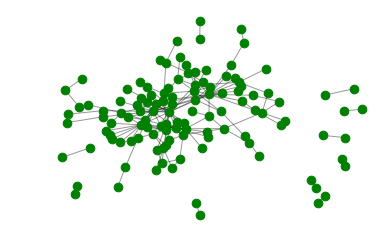

In [18]:
# plot it out
pos = nx.spring_layout(quak,k=0.2)
ec = nx.draw_networkx_edges(quak, pos, alpha=0.4)
nc = nx.draw_networkx_nodes(quak, pos, nodelist=quak.nodes(), node_color='g', cmap=plt.cm.jet, node_shape='.')
plt.axis('off')
plt.show()

Not a very pretty visualisation (.. install  [Gephy](https://gephi.org/) for some better-looking plots )
But still a few things come across:

* The graph is not connected (there are a few isolated communities)
* There seem to be a few nodes with many connections (i.e. hubs)

That's as far as we can get, let's revert to numbers for more insights

A first measure to look at is the **sparsity** of a graph with $n$ nodes is the following: 

$ L = \frac{|E|}{|E_{max}|}$, where $E_{max} = \frac{n * (n-1)}{2}$

In [19]:
# 174 * (2) / ( 119* 118)
print("Network sparsity: %.4f" %nx.density(quak))

Network sparsity: 0.0248


If the graph is not connected, how many **connected components** are there ?

In [20]:
print(nx.is_connected(quak))
comp = list(nx.connected_components(quak))
print('The graph contains', len(comp), 'connected components')

False
The graph contains 12 connected components


In [21]:
largest_comp = max(comp, key=len)
percentage_lcc = len(largest_comp)/ quak.number_of_nodes() * 100
print('The largest component has ', len(largest_comp), 'nodes', 'accounting for %.2f'% percentage_lcc, '% of the nodes') 

The largest component has  96 nodes accounting for 80.67 % of the nodes


From visually inspecting the graph, we already saw that most of the nodes are in the largest component, which is often the case in a graph. That is why we call that a **giant component**

Now suppose I want to find the shortest path between two quakers, given that they are in the same connected component

In [22]:
fell_whitehead_path = nx.shortest_path(quak, source="Margaret Fell", target="George Whitehead")
print("Shortest path between Fell and Whitehead:", fell_whitehead_path)

Shortest path between Fell and Whitehead: ['Margaret Fell', 'George Fox', 'George Whitehead']


### What is the longest shortest path between any two quakers in the giant component ? 
A.K.A **diameter**

In [23]:
# take the largest component and analyse its diameter = longest shortest path 
lcc_quak = quak.subgraph(largest_comp)
diameter = nx.diameter(lcc_quak)
print("The diameter of the largest component is", diameter)

The diameter of the largest component is 8


#### Exercise: Visually determine the diameter of the small graph we built at the beginning and then check you got it right. 

## A more social look at the network. 
### If *quaker_1* knows *quaker_2* and *quaker_2* knows *quaker_3*, how likely is that *quaker_1* and *quaker_3* know each other ? 

A.K.A **transitivity **, or the ratio of all existing triangles over all possible triangles 


In [24]:
print('%.3f'%nx.transitivity(quak))

0.169


In [26]:
# We have a similar measure but for individual nodes called clustering coefficient
print(nx.clustering(quak, ['Alexander Parker', 'John Crook']))

{'Alexander Parker': 0.06666666666666667, 'John Crook': 0.8333333333333334}


In [27]:
# Lets check by looking at the subgraphs induced by Alex and John
subgraph_Alex = quak.subgraph(['Alexander Parker']+list(quak.neighbors('Alexander Parker')))
subgraph_John = quak.subgraph(['John Crook']+list(quak.neighbors('John Crook')))

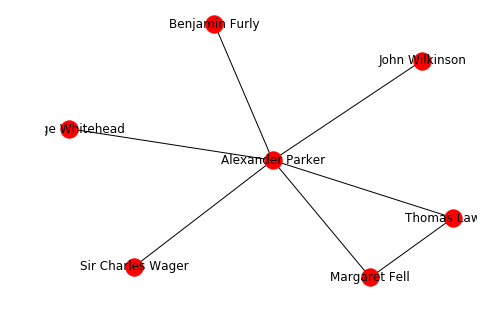

In [28]:
nx.draw_spring(subgraph_Alex, with_labels=True)

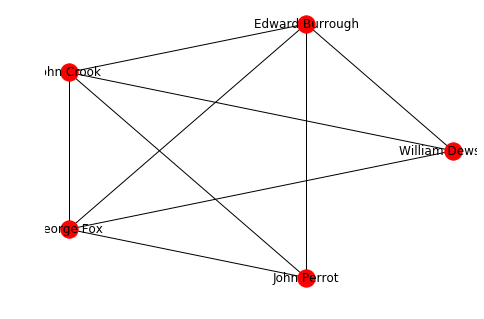

In [29]:
nx.draw_circular(subgraph_John, with_labels=True)

### Which quakers are the most important ?

As always, the answer is ... it depends. There are many ways to detect important nodes in a graph, for example based on:

* **degree**
* **betweeness centrality**

####  One view is that the more people you know, the more important you are 
**Degree** 

In [31]:
degrees = dict(quak.degree(quak.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)

# And the top 5 most popular quakers are.. 
for quaker, degree in sorted_degree[:5]:
    print(quaker, ' who is', quak.node[quaker]['Role'], 'knows', degree, 'people')

George Fox  who is  a founder of the Religious Society of Friends (Quakers) knows 22 people
William Penn  who is Quaker leader and founder of Pennsylvania knows 18 people
James Nayler  who is Quaker preacher and writer knows 16 people
George Whitehead  who is Quaker leader and writer knows 13 people
Margaret Fell  who is Quaker leader knows 13 people


Let's also see how the degree distribution looks like. 
We can see that most of the people know less than 5 quakers and there are a couple of leaders that are comparatevely very popular. 

Text(0.5, 1.0, 'Degree distribution for the Quaker network')

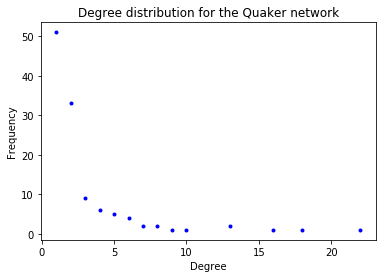

In [32]:
degree_seq = [d[1] for d in sorted_degree]
degreeCount = collections.Counter(degree_seq)
degreeCount = pd.DataFrame.from_dict( degreeCount, orient='index').reset_index()
fig = plt.figure()
ax = plt.gca()
ax.plot(degreeCount['index'], degreeCount[0], 'o', c='blue', markeredgecolor='none', markersize= 4)
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.title('Degree distribution for the Quaker network')

Note: this is an undirected graph. If you were to have a **directed** one, use separate metrics for **indegree** and **outdegree**.

### The other view is that the more shortest paths pass through a node, the more important it is. 
A.k.a: **betweeness centrality**

In [34]:
betweenness = nx.betweenness_centrality(quak) # Run betweenness centrality
# Assign each to an attribute in your network
nx.set_node_attributes(quak, betweenness, 'betweenness')
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)

for quaker, bw in sorted_betweenness[:5]:
    print(quaker, ' who is', quak.node[quaker]['Role'], 'has betweeness: %.3f' %bw)

William Penn  who is Quaker leader and founder of Pennsylvania has betweeness: 0.240
George Fox  who is  a founder of the Religious Society of Friends (Quakers) has betweeness: 0.237
George Whitehead  who is Quaker leader and writer has betweeness: 0.126
Margaret Fell  who is Quaker leader has betweeness: 0.121
James Nayler  who is Quaker preacher and writer has betweeness: 0.104


Let's get a feel of betweeness centrality for all network. As in the case with degree, there are a few nodes with very high betweeness centrality, while most of them have a low value 

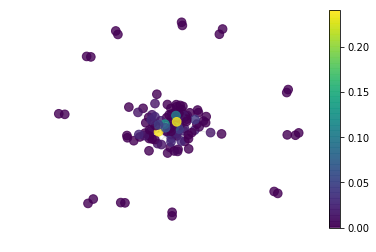

In [35]:
# similar pattern
list_nodes =list(quak.nodes())
list_nodes.reverse()   # for showing the nodes with high betweeness centrality 
pos = nx.spring_layout(quak)
ec = nx.draw_networkx_edges(quak, pos, alpha=0.1)
nc = nx.draw_networkx_nodes(quak, pos, nodelist=list_nodes, node_color=[quak.nodes[n]["betweenness"] for n in list_nodes], 
                            with_labels=False, alpha=0.8, node_shape = '.')
plt.colorbar(nc)
plt.axis('off')
plt.show()

At this point you might be tempted to think the measures are very similar, but let's revisit the original graph 

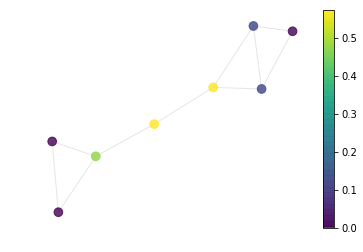

In [36]:
nx.set_node_attributes(G, nx.betweenness_centrality(G), 'betweenness')
pos = nx.spring_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha=0.1, with_labels=True)
nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), with_labels=True,node_color=[G.nodes[n]["betweenness"] for n in G.nodes()], 
                             alpha=0.8, node_shape = '.')
plt.colorbar(nc)
plt.axis('off')
plt.show()

The node with the lowest degree is the one with the highest betweeness centrality. 

This concept also translates to edges 

In particular, edge betweeness is the number of shortest paths pass through an edge. 
This brings us to ...

### The quaker communities

Community detection is a common class of methods applied to graphs. 
Two important algorithms:
* **Girvan Newman**
* **Louvain**


The idea is that the high betweeness edges separate communities. Let's see it applied on the sample graph, to get an intuition. 

The algorithm starts with the entire graph and then it iteratively removes the edges with the highest betweeness

In [38]:
comp =girvan_newman(G)
it = 0
for communities in itertools.islice(comp, 4):
    it +=1
    print('Iteration', it)
    print(tuple(sorted(c) for c in communities)) 

Iteration 1
([1, 2, 3, 4], [5, 6, 7, 8])
Iteration 2
([1, 2, 3], [4], [5, 6, 7, 8])
Iteration 3
([1, 2, 3], [4], [5], [6, 7, 8])
Iteration 4
([1], [2, 3], [4], [5], [6, 7, 8])


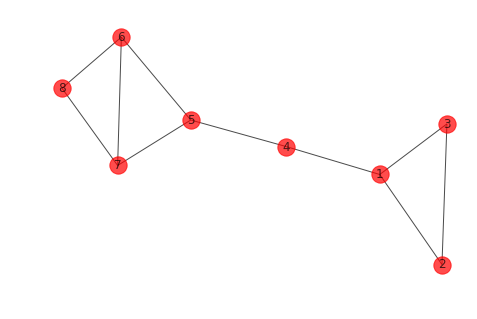

In [39]:
nx.draw_spring(G, with_labels=True,  alpha = 0.7)

#### Exercise: experiment with the Girvan Newman algorithm on our Quaker network

The [Louvain method](https://en.wikipedia.org/wiki/Louvain_Modularity) is another clustering algorithm and has become a standard algorithm in the data scientist toolbox. 

It proceeds the other way around: initially every node is considered as a community. The communities are traversed, and for each community it is tested whether by joining it to a neighboring community, we can obtain a better clustering. 


In [40]:
partition = community_louvain.best_partition(quak)
# add it as an attribute to the nodes
for n in quak.nodes:
    quak.nodes[n]["louvain"] = partition[n]

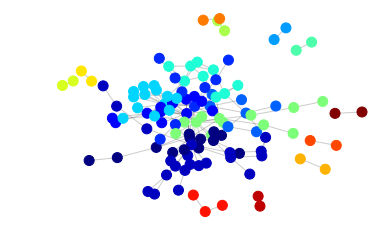

In [41]:
# plot it out
pos = nx.spring_layout(quak,k=0.2)
ec = nx.draw_networkx_edges(quak, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(quak, pos, nodelist=quak.nodes(), node_color=[quak.nodes[n]["louvain"] for n in quak.nodes], 
                            with_labels=False, node_size=100, cmap=plt.cm.jet)
plt.axis('off')
plt.show()

Let's get a closer look at a few clusters and show their member's role and period in which they lived

In [43]:
cluster_James = partition['James Nayler']
# Take all the nodes that belong to William's cluster
members_c = [q for q in quak.nodes if partition[q] == cluster_James]
# get info about these quakers
for quaker in members_c:
    print(quaker, ' who is', quak.node[quaker]['Role'], 'and died in ',quak.node[quaker]['Deathdate'])

Dorcas Erbery  who is Quaker preacher and died in  1659
James Nayler  who is Quaker preacher and writer and died in  1660
Francis Howgill  who is Quaker activist and died in  1669
Martha Simmonds  who is Quaker and author and died in  1665
Richard Farnworth  who is Quaker preacher and writer and died in  1666
William Crouch  who is Quaker leader and writer and died in  1711
Hannah Stranger  who is Quaker missionary and died in  1671
Gervase Benson  who is Quaker leader and died in  1679
Robert Rich  who is Quaker adherent and sectary and died in  1679
Anthony Pearson  who is Quaker administrator and died in  1666
William Tomlinson  who is religious writer and died in  1696
Richard Hubberthorne  who is Quaker activist and died in  1662
Thomas Aldam  who is Quaker preacher and writer and died in  1660


In [44]:
cluster_Lydia = partition['Lydia Lancaster']
# Take all the nodes that belong to William's cluster
members_c = [q for q in quak.nodes if partition[q] == cluster_Lydia]
# get info about these quakers
for quaker in members_c:
    print(quaker, ' who is', quak.node[quaker]['Role'], 'and died in ',quak.node[quaker]['Deathdate'])

Lydia Lancaster  who is Quaker minister and died in  1761
Grace Chamber  who is Quaker minister and died in  1762


### Homophily in quakers 
How likely two quakers that have the same attribute are linked?

Intuition: like correlation, but translated into graphs.

In [45]:
# for categorical attributes
nx.attribute_assortativity_coefficient(quak, 'Gender')

0.1882377889305155

There is not really gender homophily, which makes sense, due to:
* couples
* gender imbalance

In [46]:
nodes.groupby('Gender').size()

Gender
female    22
male      97
dtype: int64

However, there is age homophily: quakers that died in the same period are more likely to be linked

In [47]:
# for numerical attributes
nx.numeric_assortativity_coefficient(quak, 'Deathdate')

0.5841284189313894

#### Exercise: Compute role homophily 
You can do it based on the given roles you have or develop a more coarse categorisation of roles and repeat your analysis after. 

### Take it further 
Course given at Stanford: http://web.stanford.edu/class/cs224w/

(Better) alternative to NetworkX, see igraph: http://igraph.org/python/

For larger graph analysis:

* Graph tool: https://graph-tool.skewed.de
* Network kit: https://networkit.iti.kit.edu/api/structures.html
* SNAP: http://snap.stanford.edu/snap/
* Pajek: http://mrvar.fdv.uni-lj.si/pajek/
* Network Workbench: http://nwb.cns.iu.edu
* Apache Giraph: http://giraph.apache.org

For art: 
https://www.kirellbenzi.com/